In [120]:
# A fully parameterized implementation of Xue's Model for the effective thermal conductivity of carbon nanotube composites
# [24] Xue, Q. Z. Model for the effective thermal conductivity of carbon nanotube composites. Nanotechnology. 2006, 17, 1655–1660.
# https://iopscience.iop.org/article/10.1088/0957-4484/17/6/020/pdf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [121]:
# Model parameters
# The journal is set up so that all functions use the values listed here as defaults, but will accept overrides for any ones you want to change.

RK = 5e-8 # m^2 K/W - Interfacial Thermal Resistance (Kapitza Resistance)
f = 0.01 # The volume fraction of nanotubes in the nanocomposite

kc = 3000 # W  / (m K) - The thermal conductivity of the carbon nanotubes
km = 0.5 # W / (m K) - The thermal conductivity of the matrix material
d = 25e-9 # m - The diameter of the nanocomposite cell
L = 50000e-9 # m - The length of the nanocomposite cell. Must be > 15 for the assumptions in the equation to be valid.
M = L/d # The aspect ratio of the carbon nanotubes

def nankekm(f = f, kc = kc, km = km, L = L, d = d, RK = RK):
    ''' Nan et al formula for calculating ke/km. From https://www.sciencedirect.com/science/article/pii/S0009261403009564 

    k_e/k_m =1+φp/3  (k_c⁄k_m )/(p+2 (a_k  )/d  k_c/k_m )
    and p = L/d                  
    Args:
        f = The volume fraction of nanotubes in the nanocomposite
        kc = The thermal conductivity of the nanotubes
        km = The thermal conductivity of the matrix material
        L = The length of the nanotubes in metres
        d = The diameter of the nanotubes i metres
        RK = The interfacial Thermal Resistance
    '''

    ak = RK*km
    kekm = (1 + f*L/(d*3))*(kc/km)/(L/d + 2*(ak/d)*(kc/km))
    return kekm
    
def kct(kc = kc, RK = RK, d = d):
    ''' Calculates the transverse equivalent thermal conductivity 
    for a composite unit cell. Equivalent to kc11 in the paper.

    kc11 = kc/((1 + 2RKkc)/d)

    Args:
        kc = The thermal conductivity of the nanotubes
        RK = The interfacial thermal resistance
        d = The diameter of the composite cell
    '''
    return kc/(1 + (2*RK*kc/d))

def kcl(kc = kc, RK = RK, L = L):
    ''' Calculates the longtitudinal equivalent thermal conductivity 
    for a composite unit cell. Equivalent to kc33 in the paper.

    kc33 = kc/((1 + 2RKkc)/L)

    Args:
        kc = The thermal conductivity of the nanotubes
        RK = The interfacial thermal resistance
        L = The length of the composite cell
    '''
    return kc/(1 + (2*RK*kc/L))

In [122]:
# Helper algorithm for solving the main equation (Equation 16 from the paper) for ke
def bruteSquad(
    f = f, 
    d = d, 
    L = L, 
    km = km, 
    kct = 0.25,
    kcl = 430,
    RK = RK,
    maxIter = 200,
    increment = 0.0001,
    roughingVal = 0.02,
    direction = 1,    
    verbose = False             
):
    ''' A brute force solver to extract the ke value from the main equation. It's best to use this
    function with explicit argument names to make it easier to lean on the defaults where necessary.

    The function begins by using rough iteration to get close to the solution with minimal iterations,
    and then completes iteration using the precise iteration increment.

    Args:
        Model values:
            f = The volume fraction of nanotubes in the nanocomposite
            km = The thermal conductivity of the matrix material
            kct = The transverse thermal conductivity of the nanocomposite cell
            kcl = The longtitudinal thermal conductivity of the nanocomposite cell
            RK = The interfacial thermal resistance
            d = The diameter of the composite cell
            L = The length of the composite cell

        Brute force parameters:
            maxIter = The maximum number of iterations
            increment = The increment size for precise iteration
            roughingVal = The increment size for rough iteration
            direction = The initial iteration direction. Should be 1 or -1.
            verbose = Boolean. Turns debug messages on or off

    '''
    def debugPrint(msg):
        ''' A small helper function to avoid having to write 'if verbose' everywhere. Depends on the local
        'verbose' variable.
        Args: 
            msg = The message to print, if debug mode is on
        '''
        if verbose:
            print(msg)

    if abs(direction) - 1 != 0:
        print('Incorrect value for argument "direction". Value must be either 1 or -1.')
        print('Using default value of 1')
        direction = 1
    testKe = km # Start iteration at the current km value

    # To solve for ke, we will brute force a solution. 
    # The goal is to get 'result' to zero by incrementing the testKe.
    counter = 0
    roughing = True # Allows for rougher iteration for initial values

    bestResult = 0

    for i in range(maxIter):
        counter += 1
        term1 = 9 * (1 - f) * (testKe - km)/(2*testKe + km)
        term2 = f * (testKe - kcl)/(testKe + 0.14 * (d/L) * (kcl - testKe))
        term3 = f * 4 * (testKe - kct)/(2*testKe + (1/2)*(kct - testKe))
        bestResult = term1 + term2 + term3
        checkRes = round(bestResult/increment)
        if i == 0:
            debugPrint(f'Starting iteration at a check result of {checkRes}')
        elif maxIter < 1000:
            debugPrint(f'Checking result: {checkRes}')
        if checkRes * direction > 0:
            if roughing:
                # If we are here, we have overshot our target in the initial direction
                # and roughing can be turned off
                debugPrint(f'Passed 0 while roughing in starting direction.')
                roughing = False
                debugPrint('Roughing complete. Changing direction and increasing precision.')
                direction *= -1
            else:
                debugPrint('Passed 0 during precise iteration. Changing direction and increasing precision')
                increment /= 10
                direction *= -1
                continue
        
        if abs(checkRes) == 0:
            # Result obtained. We are done.
            break
        else:
            # Otherwise we increment in the current direction
            if roughing:
                testKe *= 1 + roughingVal * direction
            else:
                testKe *= 1 + increment * direction
        if i == maxIter:
            print(f'Max iterations reached at {iterations} iterations.')

    debugPrint(f'Final equality result: {bestResult} after {counter} iterations')
    debugPrint(f'ke value: {testKe}')
    return testKe


In [123]:
# Main equation, for use with solver

def calculateKeSolver(
    f = f, 
    d = d, 
    L = L, 
    km = km, 
    kc = kc, 
    RK = RK,
    verbose = False,
    maxIter = 500
):
    ''' Calculates the Ke, given the rest of the parameters.
    Depends on the kcl() and kct() functions defined above
    
    9(1 − f )(ke − km)/(2ke + km) 
    + f(ke − kc33)/(ke + 0.14d/L(kc33 - ke))
    + 4(ke − kc11)/(2ke + 1/2(kc11 - ke))
    = 0
    
    Args:
        f = The volume fraction of nanotubes in the nanocomposite
        km = The thermal conductivity of the matrix material
        kc = The thermal conductivity of the nanotubes
        RK = The interfacial thermal resistance
        d = The diameter of the composite cell
        L = The length of the composite cell,
        verbose = Boolean, whether or not to display bug messages from the solver.
        maxIter = Maximum number of iterations to pass to the solver
    '''
    # print(f)
    # print(d)
    # print(L)
    # print(km)
    # print(kc)
    # print(RK)
    kcTransverse = kct(kc, RK, d)
    # print(f'kc11 = {kcTransverse}')
    kcLongtitudinal = kcl(kc, RK, L)
    # print(f'kc33 = {kcLongtitudinal}')

    result =  bruteSquad(
        kct = kcTransverse, 
        kcl = kcLongtitudinal, 
        f = f, 
        d = d, 
        L = L, 
        km = km, 
        RK = RK,
        verbose = verbose,
        maxIter = maxIter
    )
    return result
        
print(calculateKeSolve(verbose = False, maxIter = 400, kc = 5000))

1.640231592915687


In [128]:
# Main equation, pre-solved for ke, with assumptions for Xue 2005
# Xue, Q. Z. Model for thermal conductivity of carbon nanotube-based composites. Physica B: Condensed Matter. 2005, 368, 302–307.Xue, Q. Z. Model for thermal conductivity of carbon nanotube-based composites. Physica B: Condensed Matter. 2005, 368, 302–307.
# https://www.sciencedirect.com/science/article/pii/S0921452605009154

def calculateKeXue2005(
        km = km,
        kc = kc,
        RK = RK,
        L = L,
        d = d,
        f = f
):
    ''' Uses the pre-solved equation from Xue 2005 (Xue-1) to calculate ke directly
    without use of a solver.

    Args:
        f = The volume fraction of nanotubes in the nanocomposite
        km = The thermal conductivity of the matrix material
        kc = The thermal conductivity of the nanotubes
        RK = The interfacial thermal resistance
        d = The diameter of the composite cell
        L = The length of the composite cell,
        verbose = Boolean, whether or not to display bug messages from the solver.
    
    Returns:
        The caculated value of ke
    '''
    numerator = 1 - f + 2 * f * (kc/(kc - km)) * np.log((kc + km)/(2 * km))
    denominator = 1 - f + 2 * f * (km/(kc - km)) * np.log((kc + km)/(2 * km))

    result = km*numerator/denominator

    return result

print()

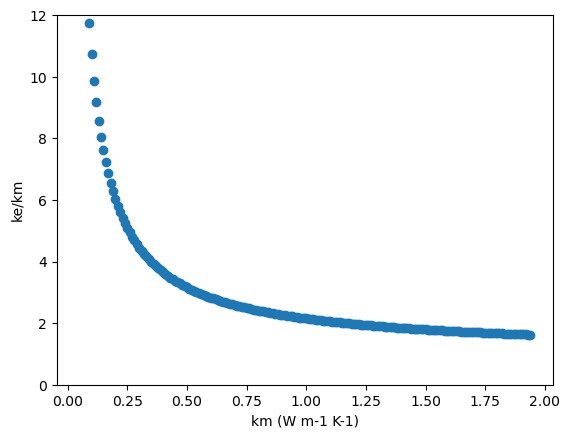

In [125]:
# Generate some data points and plot them. 

# We'll vary km and see if we can recreate the original plots from the paper
data = []
initialKm = 0.05
kmIncrement = 0.01
iterations = 190
xAxis = np.arange(start = initialKm, step = kmIncrement, stop = (initialKm + kmIncrement*iterations))
for kmValue in xAxis:
    keResult = calculateKeSolve(km = kmValue, maxIter = 500)
    data.append(keResult/kmValue)

plt.scatter(x = xAxis, y = data)
plt.xlabel('km (W m-1 K-1)')
plt.ylabel('ke/km')
plt.ylim(0, 12)
plt.show()

Generating 300 values


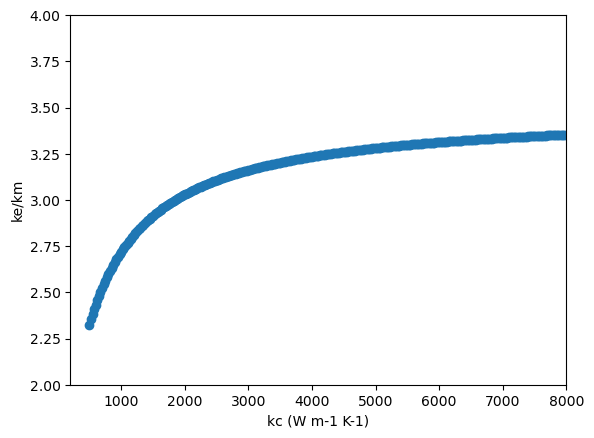

In [126]:
# Similarly, for varying kc from 500 to 7000
kcData = []
initialKc = 500
setkm = 0.5
kcIncrement = 25
kcIterations = 300
kcAxis = np.arange(start = initialKc, step = kcIncrement, stop = (initialKc + kcIncrement*kcIterations))
counter = 0

print(f'Generating {len(kcAxis)} values')
for kcValue in kcAxis:
    keResult = calculateKeSolver(kc = kcValue, km = setkm)
    kcData.append(keResult/setkm)
    counter += 1    

plt.scatter(x = kcAxis, y = kcData)
plt.xlabel('kc (W m-1 K-1)')
plt.ylabel('ke/km')
plt.xlim(200, 8000)
plt.ylim(2, 4)
plt.show()

### 

Generating 60 values


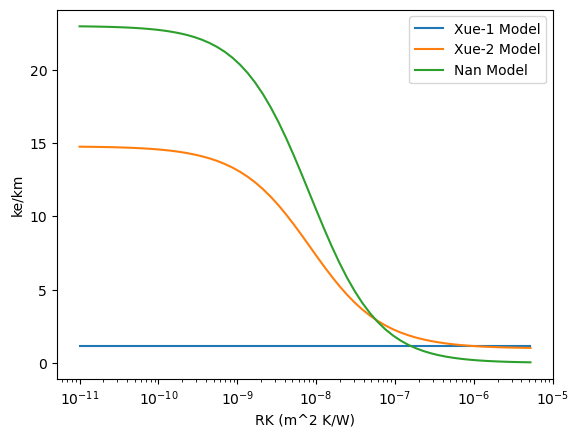

In [133]:
# Now we will plot variation of RK, and include the Nan model on the graph for reference
# Plot for RK using both the Xue and Nan models
XueData = []
NanData = []
initialRK = 1e-11
maxRK = 1e-5
kmForRK = 0.5
RKIterations = 60
RKDensity = 1.25
RKIncrement = 1

RKAxis = []

for n in range(RKIterations):
    # Calculating evenly spaced logarithmic growth using x = a*b^n and dividing by m
    # to control density of the points
    point = initialRK * RKDensity**n
    RKAxis.append(point)
counter = 0

print(f'Generating {len(RKAxis)} values')
for RKValue in RKAxis:
    # print(RKValue)
    XueSolver = calculateKeSolver(RK = RKValue, km = kmForRK)
    NanResult = nankekm(km = kmForRK, RK = RKValue)

    XueData.append(XueSolver/kmForRK)
    NanData.append(NanResult)
    #XueData.append(XueResult)
    counter += 1    

#plt.scatter(x = RKAxis, y = XueData)
plt.plot(RKAxis, XueData, label = 'Xue-2 Model')
plt.plot(RKAxis, NanData, label = 'Nan Model')

plt.xlabel('RK (m^2 K/W)')
plt.ylabel('ke/km')
plt.xscale('log')
plt.legend()
plt.show()

